## 1. Data

### Data Preprocessing

In [3]:
import pandas as pd
import networkx as nx
import string
import numpy as np

In [4]:
edges = pd.read_csv('edges.csv')

In [5]:
hero_network = pd.read_csv('hero-network.csv')

In [6]:
nodes = pd.read_csv('nodes.csv')

Removing inconsistencies

In [7]:
#Removing extra spaces at the end of the hero name
hero_network['hero1'] = hero_network['hero1'].apply(lambda x: x.rstrip())
hero_network['hero2'] = hero_network['hero2'].apply(lambda x: x.rstrip())

In [8]:
#Replace 'SPIDER-MAN/PETER PAR' with 'SPIDER-MAN/PETER PARKER'
hero_network.replace({'SPIDER-MAN/PETER PAR': 'SPIDER-MAN/PETER PARKER'}, inplace = True)

In [9]:
#Removing extra '/'
hero_network['hero1'] = hero_network['hero1'].apply(lambda x: x.rstrip('/'))
hero_network['hero2'] = hero_network['hero2'].apply(lambda x: x.rstrip('/'))
edges['hero'] = edges['hero'].apply(lambda x: x.strip('/'))

In [10]:
#After this we need to remove again the empty spaces at the end
hero_network['hero1'] = hero_network['hero1'].apply(lambda x: x.rstrip())
hero_network['hero2'] = hero_network['hero2'].apply(lambda x: x.rstrip())
edges['hero'] = edges['hero'].apply(lambda x: x.rstrip())

Removing duplicates

Let's remove rows where hero1 is equal to hero2 first.

In [11]:
hero_network.drop((hero_network[hero_network['hero1'] == hero_network['hero2']]).index, inplace = True)

Sortiamo i nomi per riga così da non avere problemi nel calcolo delle collaborazioni e dei pesi

In [12]:
hero_network = hero_network.apply(lambda row: sorted(row), axis=1, result_type='expand').set_axis(hero_network.columns, axis=1)


### Graphs setup

##### First graph

In [13]:
hero_network.groupby(['hero1', 'hero2']).size()


hero1                 hero2               
24-HOUR MAN/EMMANUEL  FROST, CARMILLA         1
                      G'RATH                  1
                      KILLRAVEN/JONATHAN R    1
                      M'SHULLA                1
                      OLD SKULL               1
                                             ..
ZEFRA                 ZON                     1
ZEUS                  ZIRAN                   1
                      ZURAS                   4
ZIRAN                 ZON                     1
                      ZURAS                   1
Length: 167100, dtype: int64

In [14]:
hero_network = hero_network.groupby(['hero1', 'hero2']).size().reset_index().rename(columns={0: 'size'})

In [15]:
hero_network

,hero1,hero2,size
0,24-HOUR MAN/EMMANUEL,"FROST, CARMILLA",1
1,24-HOUR MAN/EMMANUEL,G'RATH,1
2,24-HOUR MAN/EMMANUEL,KILLRAVEN/JONATHAN R,1
3,24-HOUR MAN/EMMANUEL,M'SHULLA,1
4,24-HOUR MAN/EMMANUEL,OLD SKULL,1
...,...,...,...
167095,ZEFRA,ZON,1
167096,ZEUS,ZIRAN,1
167097,ZEUS,ZURAS,4
167098,ZIRAN,ZON,1


In [16]:
G_hero_net = nx.Graph()

We want the graph to be weighted and we also want the weight to be lower for heroes with more collaborations, hence we take as weights the reciprocal number of the number of collaboration (the size)

In [17]:
# creating a list of 3d tuples where the first two elements are the nodes and the last is the weight
edges_l = []
hero_network.apply(lambda row : edges_l.append((row['hero1'], row['hero2'], 1/row['size'])), axis = 1)

# creating the weighted graph
G_hero_net.add_weighted_edges_from(edges_l)


In [18]:
nx.info(G_hero_net)

C:\Users\erica\AppData\Local\Temp\ipykernel_5228\1638737127.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G_hero_net)


'Graph with 6421 nodes and 167100 edges'

##### Second graph

In [22]:
G_comic_net = nx.Graph()

In [23]:
G_comic_net.add_nodes_from(list(nodes['node']))

edges_list= []
edges.apply(lambda row: edges_list.append((row['hero'], row['comic'])), axis = 1)

G_comic_net.add_edges_from(edges_list)

In [24]:
nx.info(G_comic_net)

C:\Users\erica\AppData\Local\Temp\ipykernel_5228\3041480722.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G_comic_net)


'Graph with 19519 nodes and 96104 edges'

## Backend Implementation & Frontend Implementation

### Functionality 2 - Find top superheroes!


In [179]:
N = 10
topN = edges.groupby('hero').count().sort_values(by = 'comic', ascending = False).head(N)
topN = topN.reset_index()
topN

,hero,comic
0,SPIDER-MAN/PETER PARKER,1577
1,CAPTAIN AMERICA,1334
2,IRON MAN/TONY STARK,1150
3,THING/BENJAMIN J. GR,963
4,THOR/DR. DONALD BLAK,956
5,HUMAN TORCH/JOHNNY S,886
6,MR. FANTASTIC/REED R,854
7,HULK/DR. ROBERT BRUC,835
8,WOLVERINE/LOGAN,819
9,INVISIBLE WOMAN/SUE,762


In [145]:
def functionality2(G, node, metric, N):
     #trovo i top N 
     topN = edges.groupby('hero').count().sort_values(by = 'comic', ascending = False).head(N)
     topN = topN.reset_index()

     if G == G_hero_net:
          #creo il sottografo
          subG = G.subgraph(list(topN['hero']))

          #calcolo le metriche su tutto il grafo
          if metric == 'Betweeness':
               all_values = nx.betweenness_centrality(subG, weight = 'weight')

          elif metric == 'PageRank':
               all_values = nx.pagerank(subG, weight = 'weight')

          elif metric == 'ClosenessCentrality':
               all_values = nx.closeness_centrality(subG, distance = 'weight')

          elif metric == 'DegreeCentrality':
               all_values = nx.degree_centrality(subG)

          #calcolo le metriche sul nodo passato 
          if node in subG.nodes:
               nvalue = all_values[node]
          else:
               nvalue = 'ERROR: node not in the subgraph'

          return all_values, nvalue

     if G == G_comic_net:
          # creo il sottografo prendendo nel grafo G_comic_net tutti in gli edges collegati agli eroi in topN
          reduced_edges = []
          for n in topN['hero']:
               for elem in G.edges(n):
                    reduced_edges.append(elem)
          subG = nx.Graph()
          subG.add_edges_from(set(reduced_edges))
          
          #calcolo le metriche su tutto il grafo
          if metric == 'Betweeness':
               all_values = nx.betweenness_centrality(subG)

          elif metric == 'PageRank':
               all_values = nx.pagerank(subG)

          elif metric == 'ClosenessCentrality':
               all_values = nx.closeness_centrality(subG)

          elif metric == 'DegreeCentrality':
               all_values = nx.degree_centrality(subG)

          #calcolo le metriche sul nodo passato 
          if node in subG.nodes:
               nvalue = all_values[node]
          else:
               nvalue = 'ERROR: node not in the subgraph'

          return all_values, nvalue

     

### Visualization 2 - Visualize centrality measure

In [156]:
from tabulate import tabulate

Let's start with plotting the info about the first graph "G_hero_net"

In [163]:
#calling the function on different metrics to gather all the data 

all_values, n_value = functionality2(G_hero_net, 'CAPTAIN AMERICA', 'Betweeness', 10)

col_names = ["Betweeness Centrality", "PageRank", "Closeness Centrality", "Degree centrality"]
data = [["Average value", np.mean(list(all_values.values()))], ["Node value", n_value]]

all_values, n_value = functionality2(G_hero_net, 'CAPTAIN AMERICA', 'PageRank', 10)
data[0].append(np.mean(list(all_values.values())))
data[1].append(n_value)

all_values, n_value = functionality2(G_hero_net, 'CAPTAIN AMERICA', 'ClosenessCentrality', 10)
data[0].append(np.mean(list(all_values.values())))
data[1].append(n_value)

all_values, n_value = functionality2(G_hero_net, 'CAPTAIN AMERICA', 'DegreeCentrality', 10)
data[0].append(np.mean(list(all_values.values())))
data[1].append(n_value)

print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))
#all_values = pd.DataFrame.from_dict(g, orient ='index', columns = ["metric's value"])


╒═══════════════╤═════════════════════════╤════════════╤════════════════════════╤═════════════════════╕
│               │   Betweeness Centrality │   PageRank │   Closeness Centrality │   Degree centrality │
╞═══════════════╪═════════════════════════╪════════════╪════════════════════════╪═════════════════════╡
│ Average value │               0.0361111 │  0.1       │                126.784 │                   1 │
├───────────────┼─────────────────────────┼────────────┼────────────────────────┼─────────────────────┤
│ Node value    │               0.194444  │  0.0724748 │                153.647 │                   1 │
╘═══════════════╧═════════════════════════╧════════════╧════════════════════════╧═════════════════════╛


About the second graph "G_comic_net":

In [161]:
#calling the function on different metrics to gather all the data 
all_values, n_value = functionality2(G_comic_net, 'CAPTAIN AMERICA', 'Betweeness', 10)

col_names = ["Betweeness Centrality", "PageRank", "Closeness Centrality", "Degree centrality"]
data = [["Average value", np.mean(list(all_values.values()))], ["Node value", n_value]]

all_values, n_value = functionality2(G_comic_net, 'CAPTAIN AMERICA', 'PageRank', 10)
data[0].append(np.mean(list(all_values.values())))
data[1].append(n_value)

all_values, n_value = functionality2(G_comic_net, 'CAPTAIN AMERICA', 'ClosenessCentrality', 10)
data[0].append(np.mean(list(all_values.values())))
data[1].append(n_value)

all_values, n_value = functionality2(G_comic_net, 'CAPTAIN AMERICA', 'DegreeCentrality', 10)
data[0].append(np.mean(list(all_values.values())))
data[1].append(n_value)

print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═══════════════╤═════════════════════════╤═════════════╤════════════════════════╤═════════════════════╕
│               │   Betweeness Centrality │    PageRank │   Closeness Centrality │   Degree centrality │
╞═══════════════╪═════════════════════════╪═════════════╪════════════════════════╪═════════════════════╡
│ Average value │             0.000416292 │ 0.000165044 │               0.2856   │         0.000552289 │
├───────────────┼─────────────────────────┼─────────────┼────────────────────────┼─────────────────────┤
│ Node value    │             0.269249    │ 0.0639633   │               0.390914 │         0.220205    │
╘═══════════════╧═════════════════════════╧═════════════╧════════════════════════╧═════════════════════╛


### Functionality 4 - Disconnecting Graphs

For this functionality we took a cue from the Ford-Fulkerson algorithm 


In [167]:
def DepthFirstSearch(G, node, visited):
    visited[node] = 1
    for neighbor in G.neighbors(node):
        if visited[neighbor] == 0:
            DepthFirstSearch(G, neighbor, visited)
    return 



def functionality4(G, heroA, heroB, N):
    topN = edges.groupby('hero').count().sort_values(by = 'comic', ascending = False).head(10)
    topN = topN.reset_index()

    if G == G_hero_net:
        subG = G.subgraph(list(topN['hero']))
    elif G == G_comic_net:
        reduced_edges = []
        for n in topN['hero']:
            for elem in G.edges(n):
                reduced_edges.append(elem)
        subG = nx.Graph()
        subG.add_edges_from(set(reduced_edges))

    #dizionario per segnare se ho visitato il nodo durante la ricerca in profondità
    visited = {node: 0 for node in subG.nodes}
    
    #faccio la ricerca in profondità partendo dal nodo heroA
    DepthFirstSearch(subG, heroA, visited)

    #inizializzo un contatore per il numero minimo di tagli
    counter = 0
    # e qui salverò se ho gia contato quell'edge come da tagliare
    marked = []

    # se heroA e heroB sono direttamente collegati segno l'edge come da tagliare e aumento il contatore
    if heroB in subG.neighbors(heroA):
        marked.append((heroA, heroB))
        counter += 1

    # loop su tutti i nodi del sottografo
    for node in subG.nodes:
        if node == heroB:
            continue 
        
        #se il nodo non è stato visitato vuol dire che non è collegato a heroA e lo salto
        if visited[node] == 0:
            continue
        
        # in tutti gli altri casi scorro i vicini del nodo
        for n in subG.neighbors(node):
            # se un vicino del nodo è anche vicino di heroB
            if n in subG.neighbors(heroB) and n!=heroB:
                # se non sono già passata per quell'edge
                if ((n, heroB) not in marked):
                    # segno l'edge come da tagliare e aumento il contatore
                    marked.append((n, heroB))
                    counter += 1
    
    return counter, marked, subG

### Visualization 4 - Visualize the disconnected graph

Testing on the first graph

In [123]:
heroA = 'CAPTAIN AMERICA'
heroB = 'WOLVERINE/LOGAN'
N = 10
min_num, min_edges, subG = functionality4(G_hero_net, heroA, heroB, N)

In [124]:
print('The minimum number of links that should be disconnected is', min_num)

The minimum number of links that should be disconnected is 9


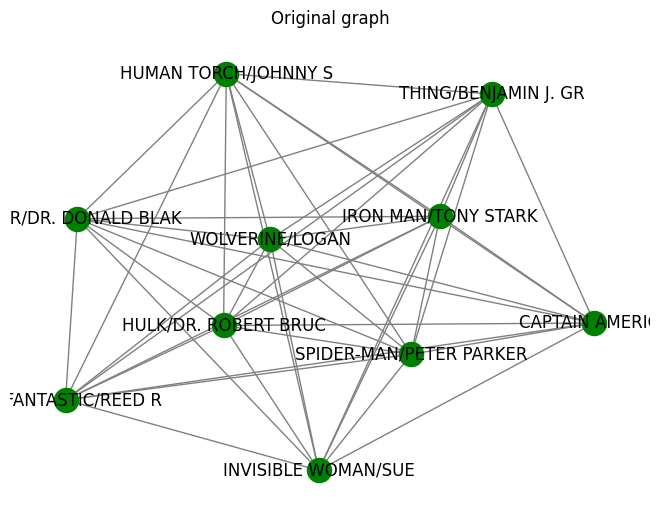

In [139]:
# plotting the orginal graph
plt.clf()
nx.draw(subG, edge_color = 'grey', node_color = 'green', with_labels = True)
plt.title('Original graph')
plt.show()

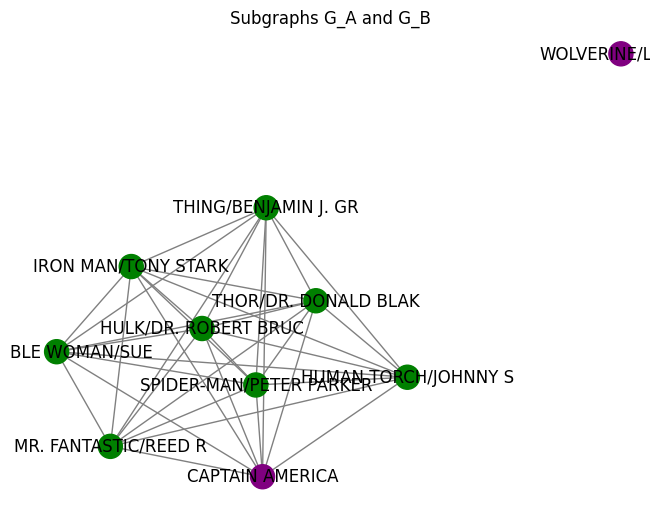

In [144]:
reduced_subG = nx.Graph(subG)
reduced_subG.remove_edges_from(list(min_edges))
plt.clf()
color_map = ['purple' if (node == heroA or node == heroB) else 'green' for node in subG]        
nx.draw(reduced_subG, node_color = color_map, edge_color = 'grey', with_labels = True)
plt.title('Subgraphs G_A and G_B')
plt.show()

Testing on the second graph

In [180]:
heroA = 'CAPTAIN AMERICA'
heroB = 'SPIDER-MAN/PETER PARKER'
N = 2
min_num, min_edges, subG = functionality4(G_comic_net, heroA, heroB, N)

In [181]:
print('The minimum number of links that should be disconnected is', min_num)

The minimum number of links that should be disconnected is 334


DIREI CHE NON SI PUO' PLOTTARE

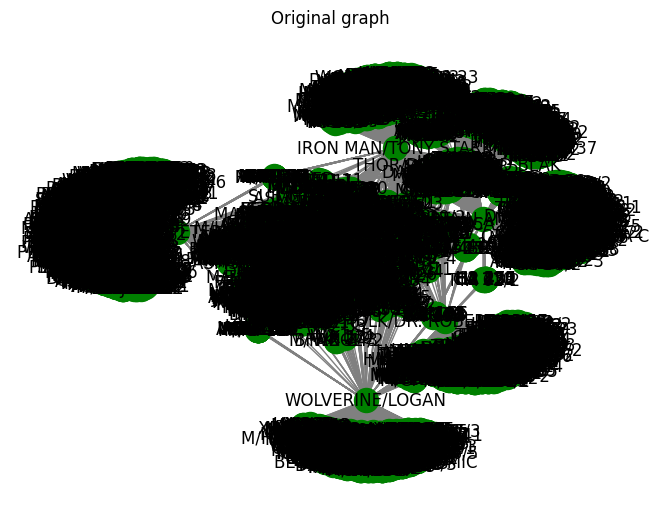

In [182]:
# plotting the orginal graph
plt.clf()
nx.draw(subG, edge_color = 'grey', node_color = 'green', with_labels = True)
plt.title('Original graph')
plt.show()